
# CardiVascular Disease Prediction & Diagnosis Using Bi-LSTM with Explainability AI


## Dataset Column Description:
    age: in years
    sex: (1 = male; 0 = female)
    cp: chest pain type
    trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    chol: serum cholestoral in mg/dl
    fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    restecg: resting electrocardiographic results
    thalach: maximum heart rate achieved
    exang: exercise induced angina (1 = yes; 0 = no)
    oldpeak: ST depression induced by exercise relative to rest
    slope: the slope of the peak exercise ST segment
    ca: number of major vessels (0-3) colored by flourosopy
    thal-- 
       | Value 0: NULL (dropped from the dataset previously) 
       | Value 1: fixed defect (no blood flow in some part of the heart) 
       | Value 2: normal blood flow 
       | Value 3: reversible defect (a blood flow is observed but it is not normal)

    target 1 or 0

## Context:
    This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. 
    In particular, the Cleveland database is the only one that has been used by ML researchers to this date. 
    The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.
    Dataset source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease


## Table of contents
    Imports Libraries
    Loading and reading dataset
    Data Description
    Exploratory Data Analysis
    Data Visualization
    Data Pre-processing
    Logistic Regression
    Conclusion

### 1. Importing libraries

In [ ]:
%pip install ctgan

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import tensorflow as tf
%matplotlib inline
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
#from sdv.tabular import TVAE
from ctgan import CTGAN

### 2. Load and reading CVD dataset

In [2]:
df = pd.read_csv('C:/Users/LENOVO/Downloads/cvd_dataset.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


### 3. Dataset Description

#### Describe
    There has been lot of confusion about the meta data, as there are various different meta data available out there. Over here below I have got the two most used meta data mentioned below. So we are going to follow the second description.

##### 1 - description

    It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,
    •    age: The person's age in years
    •    sex: The person's sex (1 = male, 0 = female)
    •    cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
    •    trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
    •    chol: The person's cholesterol measurement in mg/dl
    •    fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
    •    restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
    •    thalach: The person's maximum heart rate achieved
    •    exang: Exercise induced angina (1 = yes; 0 = no)
    •    oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
    •    slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
    •    ca: The number of major vessels (0-3)
    •    thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
    •    target: Heart disease (0 = no, 1 = yes)
    
##### 2 - description

    cp: chest pain type
    -- Value 0: asymptomatic
    -- Value 1: atypical angina
    -- Value 2: non-anginal pain
    -- Value 3: typical angina

    restecg: resting electrocardiographic results
    -- Value 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    -- Value 1: normal
    -- Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

    slope: the slope of the peak exercise ST segment
    0: downsloping; 1: flat; 2: upsloping

    thal: Results of the blood flow observed via the radioactive dye.

    Value 0: NULL (dropped from the dataset previously)
    Value 1: fixed defect (no blood flow in some part of the heart)
    Value 2: normal blood flow
    Value 3: reversible defect (a blood flow is observed but it is not normal)
    This feature and the next one are obtained through a very invasive process for the patients. 
    But, by themselves, they give a very good indication of the presence of a heart disease or not.

    target (maybe THE most important feature): 0 = disease, 1 = no disease

    A few more things to consider:
    data #93, 139, 164, 165 and 252 have ca=4 which is incorrect. In the original Cleveland dataset they are NaNs (so they should be removed)
    data #49 and 282 have thal = 0, also incorrect. They are also NaNs in the original dataset.

    I'll copy a sentence so you get more insight about the "thal" column (thal is for Thalium, a radioactive tracer injected during a stress test):
    --Nuclear stress testing requires the injection of a tracer, commonly technicium 99M (Myoview or Cardiolyte), which is then taken up by healthy, viable myocardial cells. A camera (detector) is used afterwards to image the heart and compare segments. A coronary stenosis is detected when a myocardial segment takes up the nuclear tracer at rest, but not during cardiac stress. This is called a "reversible defect." Scarred myocardium from prior infarct will not take up tracer at all and is referred to as a "fixed defect." --

    You can check all of this by comparing the Kaggle and the UCI datasets. Feel free to ask/correct/comment/say hi.

    To open a .data file, change the extension to a .txt and then open it with excel or similars.

    You're welcome!

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
df.count()

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          303
thal        303
target      303
dtype: int64

In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

<AxesSubplot: title={'center': 'Finding Null Values Using Heatmap\n'}>

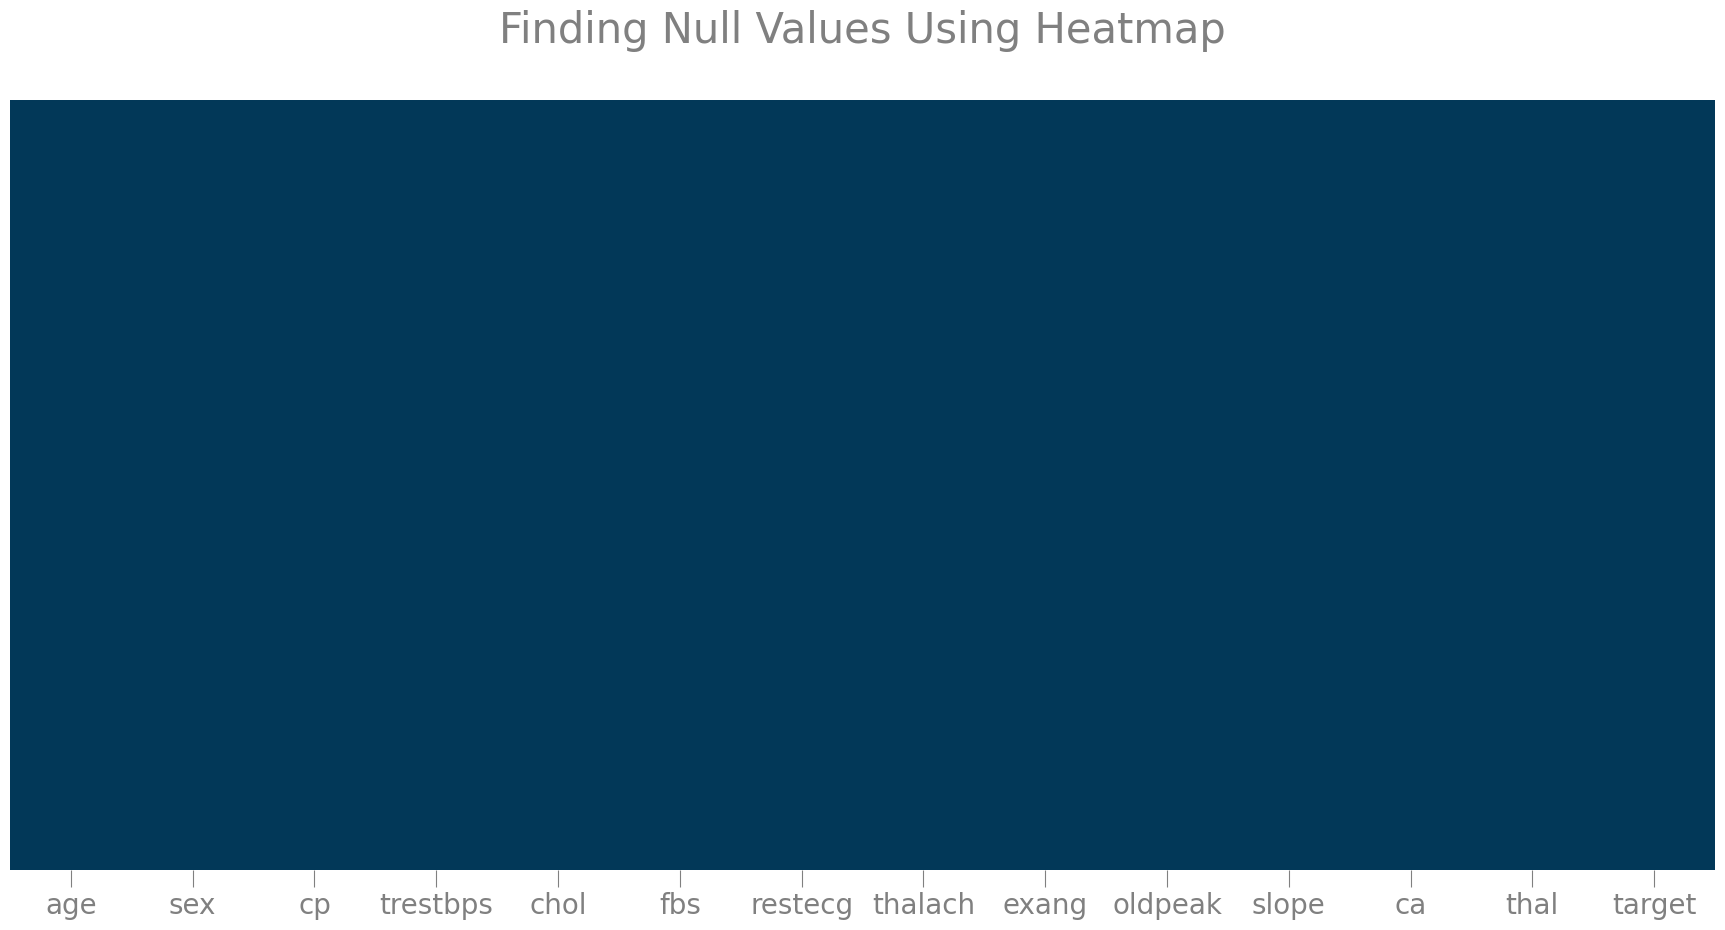

In [9]:
# visualizing null values if it exists
plt.figure(figsize=(22,10))

plt.xticks(size=20,color='grey')
plt.tick_params(size=12,color='grey')

plt.title('Finding Null Values Using Heatmap\n',color='grey',size=30)

sns.heatmap(df.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='PuBu_r',
            )

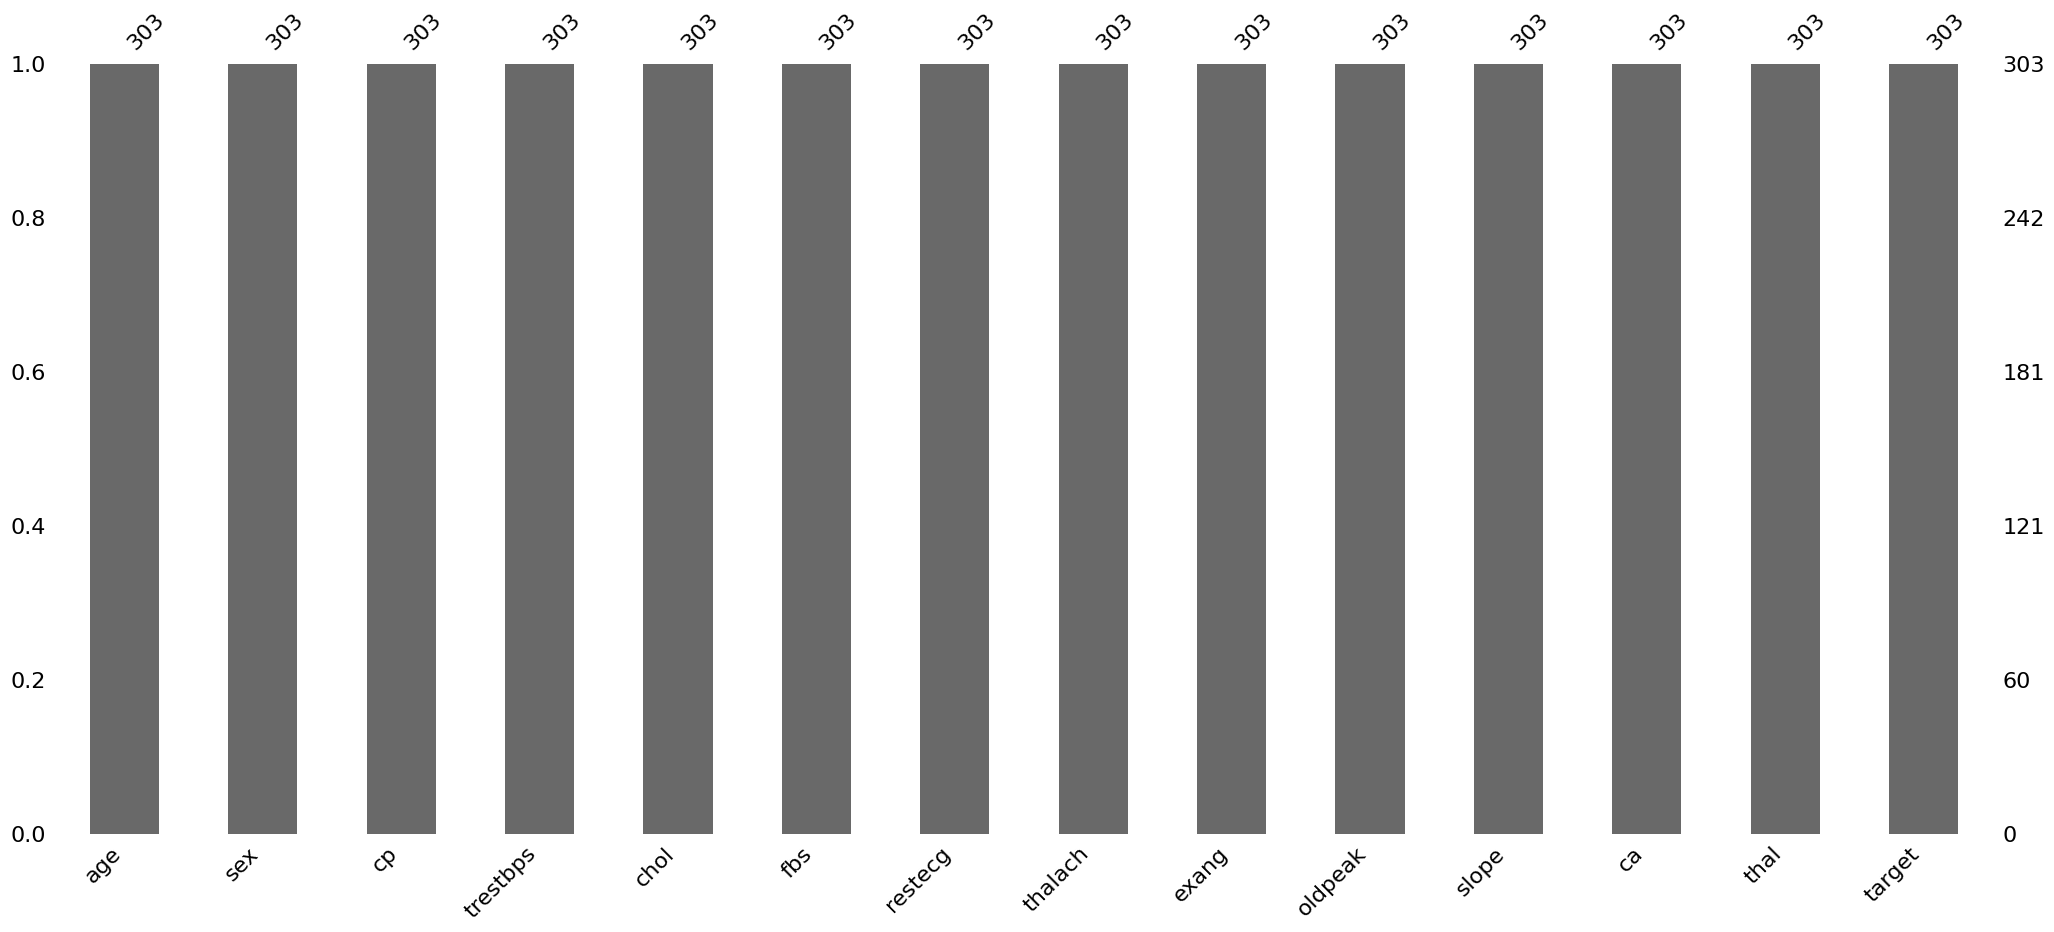

In [10]:
### using missingno library to visualize null values
#msno.matrix(df)
msno.bar(df)
plt.show()

In [11]:
import ydata_profiling as pp
pp.ProfileReport(df)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 3.Data Analysis

``` Feature Selection ```

#### 1.Univariate Selection
    Univariate Selction — Statistical tests may be used to pick certain features that have the best relationship to the performance variable. The scikit-learn library provides the SelectKBest class that can be used to select a specific number of features in a suite of different statistical tests. The following example uses the chi-squared (chi2) statistical test for non-negative features to select 10 of the best features from the Mobile Price Range Prediction Dataset.

In [15]:
# Split the data into train and test sets
data = df.copy()
X = data.iloc[:,0:13]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Reshape the input data for LSTM (assuming input shape is 2D)
X_train_lstm = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(np.array(X_test), (X_test.shape[0], X_test.shape[1], 1))

In [55]:
# Define the Bi-LSTM model
def cvd_lstm(data):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, activation='relu', return_sequences=True), input_shape=(data.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
    model.add(Dropout(0.2))
    # Add the final LSTM layer
    model.add(Bidirectional(LSTM(units=16)))
    model.add(Dense(units=1, activation='sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [56]:
cvd_lstm(X_train_lstm)

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

In [54]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

2/2 [==============================] - 0s 35ms/step - loss: 0.4467 - accuracy: 0.8197
Test Loss: 0.4467
Test Accuracy: 0.8197


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 13, 256)          133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 13, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 13, 128)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 13, 64)           41216     
 nal)                                                            
                                                        

In [33]:
print("Model Configuration:")
print("====================")
print("Loss function:", model.loss)
print("Optimizer:", model.optimizer)
print("Metrics:", model.metrics)

Model Configuration:
Loss function: binary_crossentropy
Optimizer: <keras.optimizers.adam.Adam object at 0x0000017901509300>
Metrics: [<keras.metrics.base_metric.Mean object at 0x00000179014B2C20>, <keras.metrics.base_metric.MeanMetricWrapper object at 0x00000179027E7520>]


In [57]:
# Names of the columns that are discrete
discrete_columns = [
    'age',     
    'sex',
    'cp',    
    'trestbps',
    'chol',
    'fbs',    
    'restecg',
    'thalach', 
    'exang', 
    'oldpeak', 
    'slope', 
    'ca',   
    'thal',
    'target'
]

ctgan = CTGAN(epochs=10)
ctgan.fit(df, discrete_columns)

# Create synthetic data
fake = ctgan.sample(1000)

In [58]:
fake.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
995,29,0,0,106,230,0,0,136,1,2.9,1,0,1,1
996,63,1,3,160,241,0,1,109,0,0.4,2,2,3,1
997,40,0,0,156,266,1,0,141,1,2.8,1,2,1,1
998,40,1,0,125,360,1,1,159,1,0.4,1,0,3,0
999,42,1,1,164,261,0,0,185,0,2.8,2,1,2,0


In [59]:
fake.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,55.020000,0.607000,1.120000,136.097000,249.598000,0.436000,0.78000,144.742000,0.45200,2.113500,1.116000,1.608000,1.830000,0.51000
std,11.749198,0.488661,1.126441,24.863141,59.504093,0.496135,0.75244,28.780649,0.49794,1.490291,0.770154,1.417161,1.041242,0.50015
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.00000,71.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,46.000000,0.000000,0.000000,117.000000,207.000000,0.000000,0.00000,123.000000,0.00000,0.900000,1.000000,0.000000,1.000000,0.00000
50%,55.000000,1.000000,1.000000,134.000000,244.500000,0.000000,1.00000,146.000000,0.00000,1.900000,1.000000,1.000000,2.000000,1.00000
75%,64.000000,1.000000,2.000000,152.000000,288.250000,1.000000,1.00000,168.000000,1.00000,3.125000,2.000000,3.000000,3.000000,1.00000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.00000,202.000000,1.00000,6.200000,2.000000,4.000000,3.000000,1.00000


In [60]:
fake

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,54,1,3,146,275,0,1,140,1,0.6,1,0,2,1
1,43,0,2,101,325,0,0,127,0,2.4,2,4,2,1
2,63,1,0,156,335,1,2,168,1,0.3,2,0,3,1
3,53,1,1,102,193,0,2,123,1,0.5,0,3,0,1
4,69,0,0,174,226,1,2,139,1,1.4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,29,0,0,106,230,0,0,136,1,2.9,1,0,1,1
996,63,1,3,160,241,0,1,109,0,0.4,2,2,3,1
997,40,0,0,156,266,1,0,141,1,2.8,1,2,1,1
998,40,1,0,125,360,1,1,159,1,0.4,1,0,3,0


In [61]:
# Split the fake data into train and test sets
X = fake.iloc[:,0:13]  #independent columns
y = fake.iloc[:,-1]    #target column i.e price range
fX_train, fX_test, fy_train, fy_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Reshape the generated data for LSTM (assuming input shape is 2D)
fX_train_lstm = np.reshape(np.array(fX_train), (fX_train.shape[0], fX_train.shape[1], 1))
fX_test_lstm = np.reshape(np.array(fX_test), (fX_test.shape[0], fX_test.shape[1], 1))

In [64]:
cvd_lstm(fX_train_lstm)
model.fit(fX_train, fy_train, batch_size=32, epochs=20, validation_data=(fX_test, fy_test))

Epoch 1/20
25/25 [==============================] - 3s 107ms/step - loss: 0.7636 - accuracy: 0.4950 - val_loss: 0.6975 - val_accuracy: 0.4800
Epoch 2/20
25/25 [==============================] - 3s 105ms/step - loss: 0.6938 - accuracy: 0.4950 - val_loss: 0.6924 - val_accuracy: 0.5250
Epoch 3/20
25/25 [==============================] - 3s 105ms/step - loss: 0.6938 - accuracy: 0.5063 - val_loss: 0.6917 - val_accuracy: 0.4900
Epoch 4/20
25/25 [==============================] - 3s 107ms/step - loss: 0.6913 - accuracy: 0.5113 - val_loss: 0.6895 - val_accuracy: 0.5250
Epoch 5/20
25/25 [==============================] - 3s 105ms/step - loss: 0.6925 - accuracy: 0.5050 - val_loss: 0.6892 - val_accuracy: 0.5550
Epoch 6/20
25/25 [==============================] - 3s 102ms/step - loss: 0.6957 - accuracy: 0.4900 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 7/20
25/25 [==============================] - 3s 102ms/step - loss: 0.6950 - accuracy: 0.4925 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 

In [65]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(fX_test, fy_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

7/7 [==============================] - 0s 38ms/step - loss: 0.6935 - accuracy: 0.5050
Test Loss: 0.6935
Test Accuracy: 0.5050
